In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import alpaca_trade_api as tradeapi

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
import requests
import os
from dotenv import load_dotenv

In [4]:
load_dotenv()
alpaca_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_key

'PKPSAHJHLXAG7R9BBDZX'

In [5]:
api = tradeapi.REST(alpaca_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [6]:
# get assets and keep only the tradeable ones
assets = api.list_assets()
tradable = [asset for asset in assets if asset.tradable]
#tradable

In [7]:
#Create a DataFrame to pull SPY and AGG data from
assets_df = pd.DataFrame()
assets_df['Symbol'] = pd.Series([asset.symbol for asset in assets])

display(assets_df.head())

,Symbol
0,EDC
1,NITE
2,AFB
3,CCJ
4,MORT


In [8]:
list_of_tickers = ["SPY", "AGG"]

In [9]:
#Setting timeframe for data pull
timeframe = '1D'

end_date = datetime.now()
start_date = end_date + timedelta(-365)

#putting data from that timeframe into a df
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AGG                                        \
                             open      high      low     close   volume   
2019-11-15 00:00:00-05:00  112.46  112.4600  112.380  112.4100  3961721   
2019-11-18 00:00:00-05:00  112.56  112.6460  112.520  112.5950  5550696   
2019-11-19 00:00:00-05:00  112.63  112.7600  112.600  112.7100  2181200   
2019-11-20 00:00:00-05:00  112.83  112.9800  112.805  112.9700  3218845   
2019-11-21 00:00:00-05:00  112.80  112.8859  112.720  112.8131  3971410   

                              SPY                                    
                             open    high     low   close    volume  
2019-11-15 00:00:00-05:00  311.02  311.83  310.26  311.82  42549412  
2019-11-18 00:00:00-05:00  311.53  312.28  311.03  312.00  40559312  
2019-11-19 00:00:00-05:00  312.68  312.69  311.22  311.91  56892505  
2019-11-20 00:00:00-05:00  311.28  311.85  309.06  310.79  62833225  
2019-11-21 00:00:00-05:00  310.89  311.01  309.39  310.29  42497606

In [10]:
df.columns

MultiIndex([('AGG',   'open'),
            ('AGG',   'high'),
            ('AGG',    'low'),
            ('AGG',  'close'),
            ('AGG', 'volume'),
            ('SPY',   'open'),
            ('SPY',   'high'),
            ('SPY',    'low'),
            ('SPY',  'close'),
            ('SPY', 'volume')],
           )

In [11]:
#dropping anything that is not the date or closing price
df = df.droplevel(axis=1, level=0)
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df.index = df.index.date
df.head()

,close,close
2019-11-15,112.4100,311.82
2019-11-18,112.5950,312.00
2019-11-19,112.7100,311.91
2019-11-20,112.9700,310.79
2019-11-21,112.8131,310.29


In [12]:
df.columns = ['SPY Close', 'AGG Close']
df

,SPY Close,AGG Close
2019-11-15,112.4100,311.82
2019-11-18,112.5950,312.00
2019-11-19,112.7100,311.91
2019-11-20,112.9700,310.79
2019-11-21,112.8131,310.29
...,...,...
2020-04-03,115.0000,248.21
2020-04-06,115.5800,264.97
2020-04-07,115.6900,265.10
2020-04-08,115.8100,274.07


In [13]:
spy_df = df['SPY Close']
agg_df = df['AGG Close']
agg_df

2019-11-15    311.82
2019-11-18    312.00
2019-11-19    311.91
2019-11-20    310.79
2019-11-21    310.29
               ...  
2020-04-03    248.21
2020-04-06    264.97
2020-04-07    265.10
2020-04-08    274.07
2020-04-09    278.24
Name: AGG Close, Length: 100, dtype: float64

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [14]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns

,SPY Close,AGG Close
2019-11-18,0.001646,0.000577
2019-11-19,0.001021,-0.000288
2019-11-20,0.002307,-0.003591
2019-11-21,-0.001389,-0.001609
2019-11-22,0.000327,0.002288
...,...,...
2020-04-03,0.000435,-0.014531
2020-04-06,0.005043,0.067523
2020-04-07,0.000952,0.000491
2020-04-08,0.001037,0.033836


In [15]:
avg_returns_spy = daily_returns.mean()['SPY Close']
avg_returns_agg = daily_returns.mean()['AGG Close']
avg_returns_spy

0.0004497877647728977

In [16]:
# Calculate volatility
# Using Standard Deviation to measure volatility b/c variance is lame
std_spy = daily_returns.std()['SPY Close']
std_agg = daily_returns.std()['AGG Close']
std_spy

0.008479347676750357

In [17]:
# Save the last day's closing price
last_day_spy = spy_df.iloc[-1]
last_day_agg = agg_df.iloc[-1]
last_day_agg

278.24

In [18]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [19]:
# Run the Monte Carlo Simulation for SPY
for n in range(number_simulations):
    
    sim_spy_prices = [last_day_spy]
    sim_agg_prices = [last_day_agg]
    
    for i in range(number_records):
        simulated_spy_price = sim_spy_prices[-1] * (1 + np.random.normal(avg_returns_spy, std_spy))
        simulated_agg_price = sim_agg_prices[-1] * (1 + np.random.normal(avg_returns_agg, std_agg))
        
        
        sim_spy_prices.append(simulated_spy_price)
        sim_agg_prices.append(simulated_agg_price)
        
    monte_carlo["SPY Prices"] = pd.Series(sim_spy_prices)
    monte_carlo["AGG Prices"] = pd.Series(sim_agg_prices)

monte_carlo

,SPY Prices,AGG Prices
0,117.110000,278.240000
1,116.704267,268.177182
2,117.319188,273.024609
3,116.859892,280.120925
4,117.551199,279.059408
...,...,...
7556,782.946198,0.139463
7557,774.927001,0.137946
7558,767.357570,0.139871
7559,768.112705,0.135270


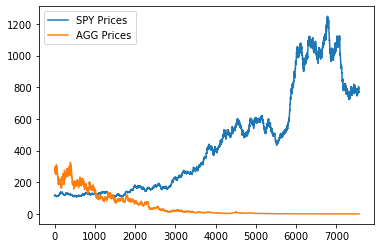

In [21]:
# Visualize the Simulation
monte_carlo.plot()

In [23]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
end_price = monte_carlo.iloc[-1]
end_price

SPY Prices    769.057320
AGG Prices      0.139027
Name: 7560, dtype: float64

In [26]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
yr_price = monte_carlo.iloc[5040]
yr_price

SPY Prices    600.166610
AGG Prices      3.259441
Name: 5040, dtype: float64

In [27]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
ci = monte_carlo.quantile(q=[.05, .95])
ci

,SPY Prices,AGG Prices
0.05,114.353540,0.148814
0.95,1065.992867,212.346717


In [ ]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure();


---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [ ]:
# YOUR CODE HERE

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [ ]:
# YOUR CODE HERE

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [ ]:
# YOUR CODE HERE

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# YOUR CODE HERE

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [29]:
# YOUR CODE HERE


NameError: name 'pwd' is not defined